# EDA of "ChatGPT Classification Dataset"
#### Kaggle description
We have compiled a dataset that consists of textual articles including common terminology, concepts and definitions in the field of computer science, artificial intelligence, and cyber security. This dataset consists of both human-generated text and OpenAI’s ChatGPT-generated text. Human-generated answers were collected from different computer science dictionaries and encyclopedias including “The Encyclopedia of Computer Science and Technology” and "Encyclopedia of Human-Computer Interaction". AI-generated content in our dataset was produced by simply posting questions to OpenAI’s ChatGPT and manually documenting the resulting responses. A rigorous data-cleaning process has been performed to remove unwanted Unicode characters, styling and formatting tags. To structure our dataset for binary classification, we combined both AI-generated and Human-generated answers into a single column and assigned appropriate labels to each data point (Human-generated = 0 and AI-generated = 1).

This creates our article-level dataset (article_level_data.csv) which consists of a total of 1018 articles, 509 AI-generated and 509 Human-generated. Additionally, we have divided each article into its sentences and labelled them accordingly. This is mainly to evaluate the performance of classification models and pipelines when it comes to shorter sentence-level data points. This constructs our sentence-level dataset (sentence_level_data.csv) which consists of a total of 7344 entries (4008 AI-generated and 3336 Human-generated). 

In [1]:
import pandas as pd
import re
import unicodedata
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from nltk.probability import FreqDist # This is for counting the most frequent words
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize # this is for counting the senteces
plt.style.use('ggplot')

from collections import Counter
from functools import reduce
import language_tool_python
import lmppl

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter


# Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("article_level_data.csv" , index_col= False )
data = data.drop(columns=["Unnamed: 0"])
data.head(5)

,article,class
0,NLP is a multidisciplinary field that draws fr...,0
1,There are a variety of emerging applications f...,0
2,As each new means of communication and social ...,0
3,"These suggestions include:, Learn about the pu...",0
4,In recent years there has been growing concern...,0


In [4]:
print(data.shape)
data.info()

(1018, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  1018 non-null   object
 1   class    1018 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.0+ KB


In [5]:
# Checking missing values...
data.isna().sum()

article    0
class      0
dtype: int64

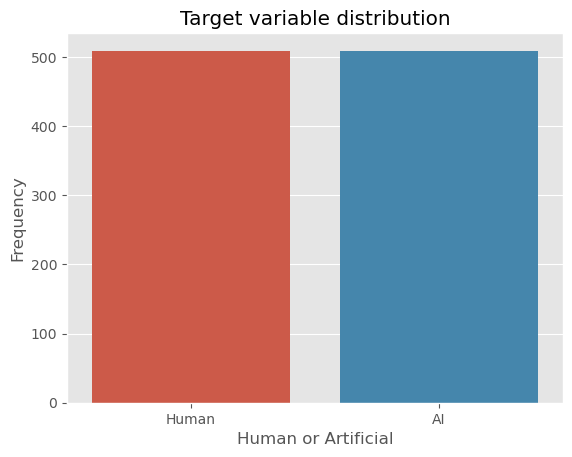

In [6]:
# Let's see the target class distribution
fig = sns.countplot(data, x = 'class')
fig.set(title = 'Target variable distribution', xlabel = 'Human or Artificial', ylabel = 'Frequency', xticklabels=['Human','AI'] )
plt.show()
# We have a very balanced dataset

# EDA --> Counts and lengths

#### Character Count

In [7]:
def article_length(text):
    return len(text)

data['length'] = data['article'].apply(article_length) 

In [8]:
print(data[data['class']==0].length.mean())
print(data[data['class']==1].length.mean())
# Not a big difference in the article's length

905.5795677799607
1124.7976424361493


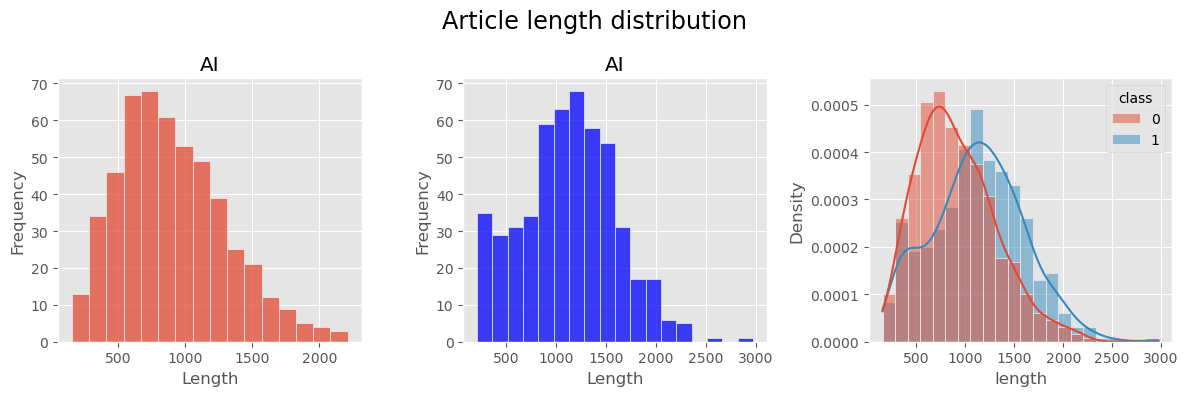

In [9]:
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['class']==0], x = 'length', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['class']==1], x = 'length', ax = axes[1], color = 'blue')
fig_dist_ai.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig.suptitle('Article length distribution', fontsize =  'xx-large')
sns.histplot(data = data, x = 'length', hue="class", kde= True, stat = 'density', ax = axes[2] ) # Overlapped
plt.tight_layout()
# We can see that the AI articles are a bit longer but not so much

#### Words count

In [10]:
data['words'] = data['article'].apply(lambda x: len(str(x).split()))

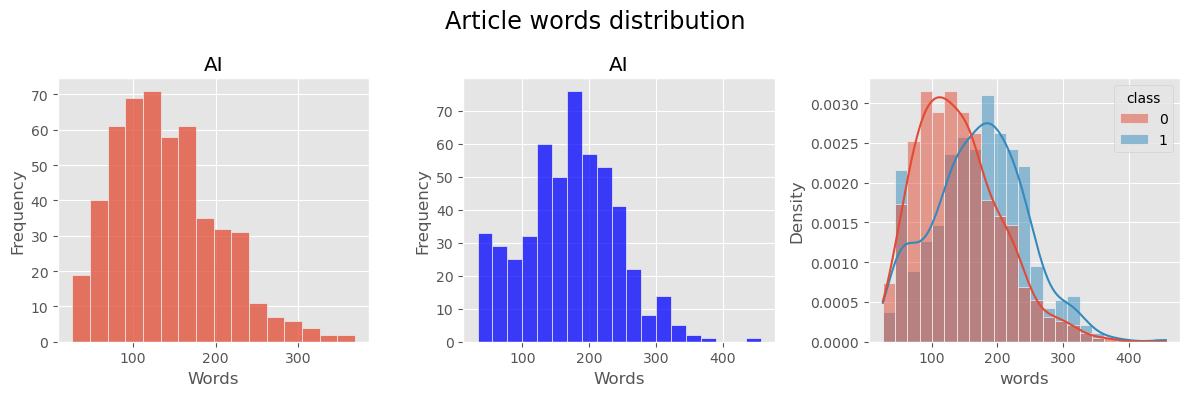

In [11]:
figg, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['class']==0], x = 'words', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['class']==1], x = 'words', ax = axes[1], color='blue')
fig_dist_ai.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
sns.histplot(data = data, x = 'words', hue='class', kde= True, stat = 'density', ax = axes[2]) 
figg.suptitle('Article words distribution', fontsize =  'xx-large')
plt.tight_layout()

# It is not the same as before, the x-axis is different! But of course they are similar because we are counting the words and the lenghts

#### Sentence Count

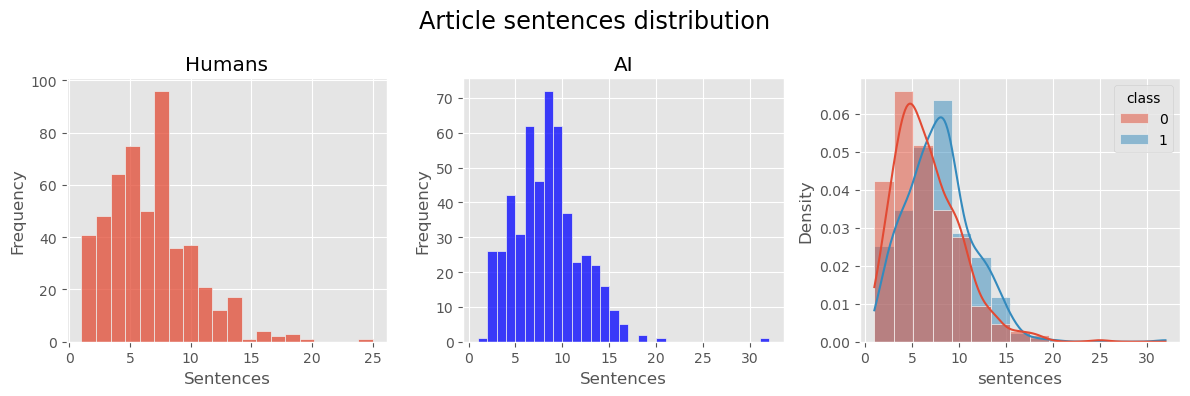

In [12]:
data['sentences'] = data['article'].map(lambda x: len(sent_tokenize(x)))
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_sentences_human = sns.histplot(data = data[data['class']==0], x = 'sentences', ax = axes[0])
fig_sentences_human.set(title = 'Humans', xlabel='Sentences', ylabel= 'Frequency')
fig_sentences_ai = sns.histplot(data = data[data['class']==1], x = 'sentences', ax = axes[1], color='blue')
fig_sentences_ai.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
sns.histplot(data = data, x = 'sentences', hue='class', kde= True, stat = 'density', ax = axes[2], bins = 15) 
fig.suptitle('Article sentences distribution', fontsize =  'xx-large')
plt.tight_layout()

# EDA --> Term frequency analysis

Steps I will follow:
1) Convert to lowercase
2) remove urls and html tags if any
3) Remove strange acceted characters if any
4) Remove punctuation
5) Remove extra white spaces 
6) Delet stop words

In [13]:
def lowering(text):
    return text.lower()

data['article_clean'] = data.article.apply(lowering)   

In [14]:
len(data[data.article_clean.str.contains('http')]) # there are 23 links, we can remove or not them, to be decided

23

In [15]:
def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

data['article_clean'] = data.article_clean.apply(remove_url)

In [16]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

data['article_clean'] = data.article_clean.apply(remove_accents)

In [17]:
def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

data['article_clean'] = data.article_clean.apply(remove_punctuation)

In [18]:
def remove_extra_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

data['article_clean'] = data.article_clean.apply(remove_extra_spaces)
data['article_nopunct'] = data.article_clean.copy()

In [19]:
# Spacy: 326 words to eliminate
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [20]:
# Delete stop words
def delete_stopwords(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

# Create new columns with new text and new length
data['article_clean'] = data.article_clean.apply(delete_stopwords)

In [21]:
def most_common_words(data):
    corpus = [word for i in data['article_clean'].str.split().values.tolist() for word in i]
    most_common = FreqDist(corpus).most_common(40)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return dict(zip(words, frequency))

In [22]:
most_1_human = most_common_words(data[data['class']==0])
most_1_ai = most_common_words(data[data['class']==1])

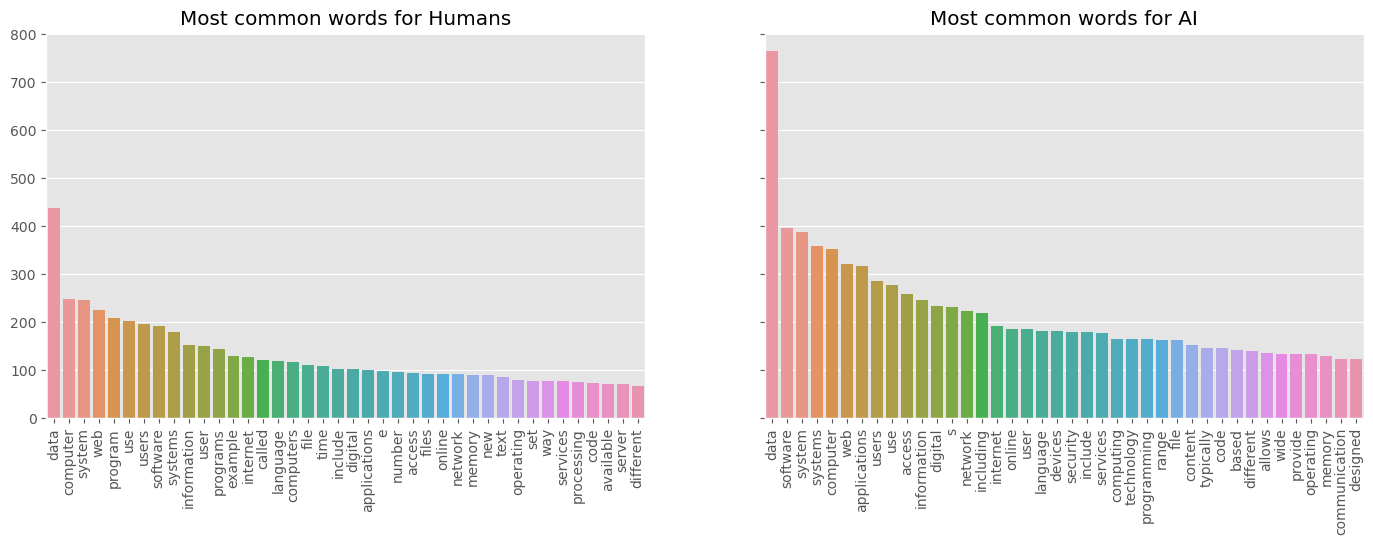

In [23]:
fig, axes = plt.subplots(1,2, figsize = (17,5), sharey= True)
sns.barplot(x = list(most_1_human.keys()), y = list(most_1_human.values()), ax = axes[0]).set(title="Most common words for Humans")
sns.barplot(x = list(most_1_ai.keys()), y = list(most_1_ai.values()), ax = axes[1]).set(title="Most common words for AI")
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.show()

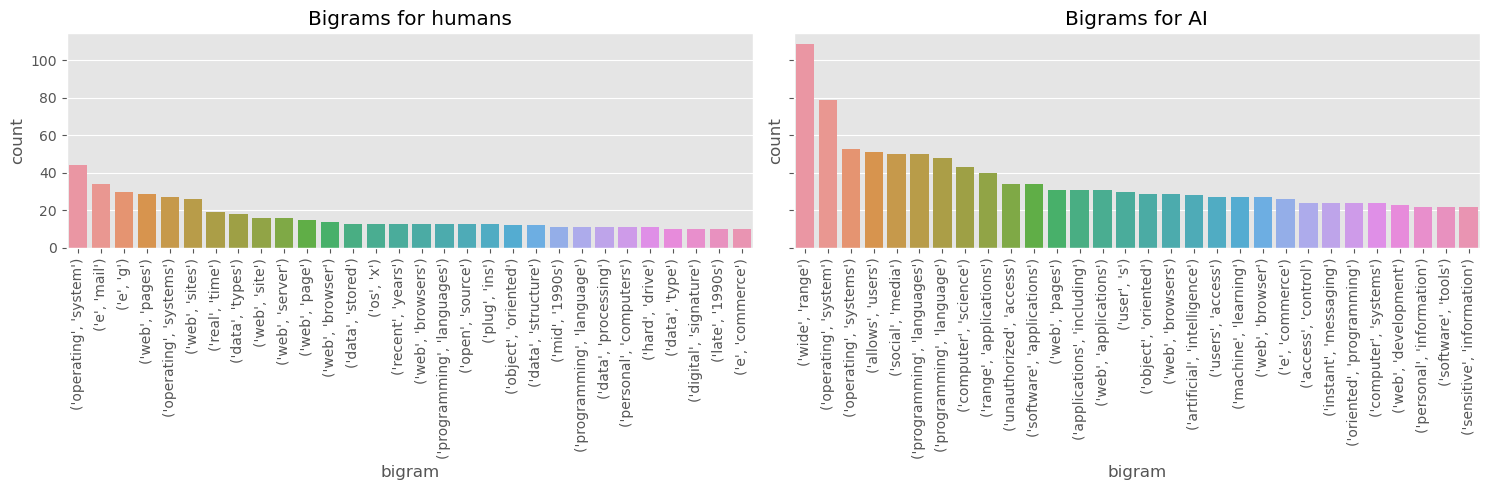

In [24]:
humans = data[data['class']==0]
corpus_humans = [word for i in humans.article_clean.str.split().values.tolist() for word in i]
bigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 2)).value_counts())
bigrams_df_h = bigrams_humans.reset_index()
bigrams_df_h.columns = ['bigram', 'count']

AI = data[data['class']==1]
corpus_AI = [word for i in AI.article_clean.str.split().values.tolist() for word in i]
bigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 2)).value_counts())
bigrams_df_AI = bigrams_AI.reset_index()
bigrams_df_AI.columns = ['bigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,5), sharey=True)
sns.barplot(bigrams_df_h.head(30), x = 'bigram', y ='count', ax=axes[0]).set(title = 'Bigrams for humans')
sns.barplot(bigrams_df_AI.head(30), x = 'bigram', y ='count', ax=axes[1]).set(title = 'Bigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

# Look! AI has very high frequences while humans at max 40 but I still need to fix tha data :)

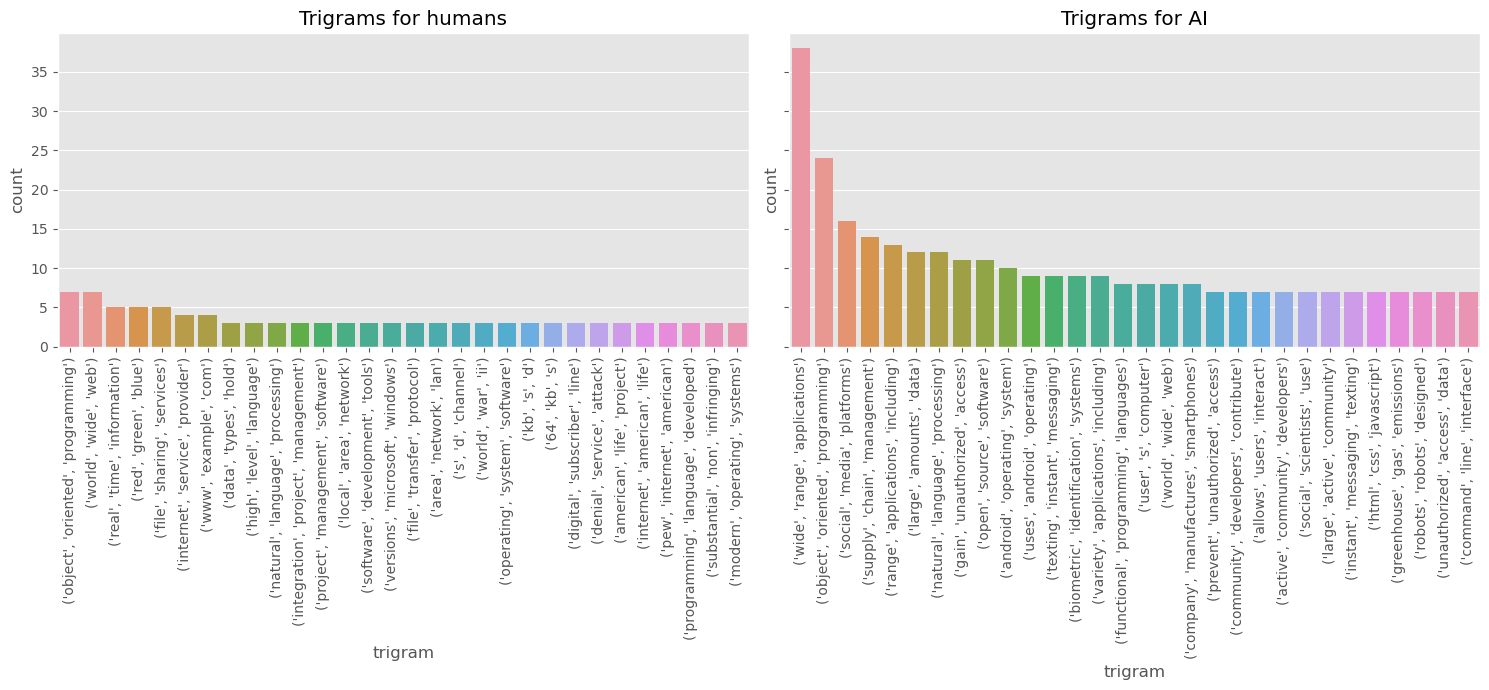

In [25]:
trigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 3)).value_counts())
trigrams_df_h = trigrams_humans.reset_index()
trigrams_df_h.columns = ['trigram', 'count']

trigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 3)).value_counts())
trigrams_df_AI = trigrams_AI.reset_index()
trigrams_df_AI.columns = ['trigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,7), sharey= True) 
sns.barplot(trigrams_df_h.head(30), x = 'trigram', y ='count', ax=axes[0]).set(title = 'Trigrams for humans')
sns.barplot(trigrams_df_AI.head(30), x = 'trigram', y ='count', ax=axes[1]).set(title = 'Trigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

### Logistic Regression with Gradient Ascent

We employ the logistic regression model as the initial approach for our classification task.

Logistic Regression uses as hypothesis the sigmoid function, which represents the probability that an instance belongs to a specific class, in this case the probability that the article is written by ChatGPT<br>

hypothesis $h_\theta(x)= P(y=1|x;\theta)$ $=\frac{1}{1+\exp(-\theta^T x)}$

The training process involves finding the set of parameters θ that maximizes the likelihood of the observed data. 

\begin{align}
L(\theta) &= \prod_{i=1}^{m} h_\theta(x^{(i)})^{y^{(i)}} \left( 1 - h_\theta(x^{(i)}) \right)^{1 - y^{(i)}} \\
L(\theta) &= \prod_{i=1}^{m} \left( \frac{1}{1 + e^{-\theta^T x^{(i)}}} \right)^{y^{(i)}} \left(1 - \frac{1}{1 + e^{-\theta^T x^{(i)}}}\right)^{1 - y^{(i)}}
\end{align}

where y is the class label of th i-th example (0 or 1), x is the i-th input data, θ are the model parameters, and m is the number of examples in the training set.


In logistic regression, this is typically done by maximizing the log-likelihood. The likelihood function represents the probability of observing the given set of outcomes (classes) for the input data. The log-likelihood is used for mathematical convenience, and the optimization problem becomes finding the parameters that maximize the log-likelihood.

\begin{align}
l(\theta) &= \log L(\theta) \\
l(\theta) &= \sum_{i=1}^{m} \left[ (y^{(i)} - 1) \theta^T x^{(i)} - \log (1 + e^{\theta^T x^{(i)}}) \right] 
\end{align}

The gradient of the log likelihood with respect to the parameters θ is calculated as follows:

\begin{align}
\frac{\partial l(\theta)}{\partial \theta} &= \sum_{i=1}^{m} \left[ (y^{(i)} - h_\theta(x^{(i)})) x^{(i)} \right] \\
\frac{\partial l(\theta)}{\partial \theta} &= \sum_{i=1}^{m} \left[ (y^{(i)} - 1) x^{(i)} - \frac{e^{\theta^T x^{(i)}}}{1 + e^{\theta^T x^{(i)}}} \cdot x^{(i)} \right] \\
\end{align}

To maximize the log likelihood, optimization methods like gradient ascent are used. 

For \( j=0,...,n \), where n is the number of features:
\begin{equation}
\theta_j := \theta_j + \alpha \left[ \sum_{i=1}^{m} \left( y^{(i)} - h_\theta(x^{(i)}) \right) x_j^{(i)} \right]
\end{equation}

where α is the learning rate, i is the index of the example and j is the index of the element of the i-th example.

The process continues until convergence is reached or a stopping criterion is satisfied.

#### Definition of the functions needed for the Logistic Regression Model

In [26]:
# Function to compute the sigmoid of a given input x.
def sigmoid(x):
    g = 1 / (1 + np.exp(-x))
    return g


# Function to compute the log likehood of theta according to data x and label y.
def log_likelihood(theta, x, y):
    
    h = sigmoid(np.dot(x, theta))
    log_l = np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
    return log_l


# Function to compute the predictions for the input features.
def predictions(features, theta):
    
    preds = sigmoid(np.dot(features, theta))
    return preds


#  Function to compute the gradient of the log likelihood and then return the updated weights.
def update_theta(theta, target, preds, feat, lr):
    
    gradient = np.dot(feat.T, (target - preds)) / feat.shape[0]
    theta += lr * gradient
    return theta
    

# Function to execute the gradient ascent algorithm.
def gradient_ascent(theta, feat, target, lr, num_steps):
    
    log_likelihood_history = []
    
    for step in range(num_steps):
        preds = predictions(feat, theta)
        theta = update_theta(theta, target, preds, feat, lr)
        log_l = log_likelihood(theta, feat, target)
        log_likelihood_history.append(log_l)
        
    return theta, log_likelihood_history

### LOGISTIC REGRESSION with TF-IDF

Let's begin by applying a Logistic Regression model to a DataFrame, where the feature values are derived from the TF-IDF transformation of the "article" column. This transformation is performed after preprocessing the strings and stemming their words.

In [97]:
# import libraries for tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [98]:
data.head()

,Unnamed: 0,article,class,length,words,sentences,article_clean,total_bigram_count,article_nopunct,article_list,herdan,maas,simpson,grammar_score,TTR1,TTR2,TTR3,avg_token_length,perplexity
0,0,NLP is a multidisciplinary field that draws fr...,0,1112,187,6,nlp multidisciplinary field draws linguistics ...,3,nlp is a multidisciplinary field that draws fr...,"['nlp', 'is', 'a', 'multidisciplinary', 'field...",1.778976,0.218939,0.984157,0.021390,0.609626,0.988235,1.0,4.804348,35.369075
1,1,There are a variety of emerging applications f...,0,630,82,2,variety emerging applications nlp including fo...,0,there are a variety of emerging applications f...,"['there', 'are', 'a', 'variety', 'of', 'emergi...",2.111778,0.263233,0.978882,0.036585,0.768293,1.000000,1.0,6.250000,58.814785
2,2,As each new means of communication and social ...,0,1135,176,8,new means communication social interaction int...,0,as each new means of communication and social ...,"['as', 'each', 'new', 'means', 'of', 'communic...",1.799834,0.222197,0.985182,0.022727,0.693182,0.989691,1.0,5.285714,53.423985
3,3,"These suggestions include:, Learn about the pu...",0,1018,173,10,suggestions include learn purpose newsgroup po...,1,these suggestions include learn about the purp...,"['these', 'suggestions', 'include', 'learn', '...",1.805839,0.223120,0.986100,0.034682,0.647399,0.987013,1.0,4.779762,34.250844
4,4,In recent years there has been growing concern...,0,699,111,3,recent years growing concern internet users ev...,1,in recent years there has been growing concern...,"['in', 'recent', 'years', 'there', 'has', 'bee...",1.975996,0.246963,0.982225,0.027027,0.702703,0.983607,1.0,5.284404,25.693995


In [99]:
# create a new DataFrame called df, dropping the columns that we don't want to use from the original dataset
df = data.drop(columns=["article", "length", "words", "sentences"])

# reorders the columns
df = df[['article_clean', 'class']]

df.head()

,article_clean,class
0,nlp multidisciplinary field draws linguistics ...,0
1,variety emerging applications nlp including fo...,0
2,new means communication social interaction int...,0
3,suggestions include learn purpose newsgroup po...,0
4,recent years growing concern internet users ev...,0


In the updated DataFrame, denoted as "df," there are only two columns: "article_clean," storing the preprocessed articles presented as strings, and "class" representing the corresponding label (0 for human, 1 for ChatGPT).

Moving forward, our next step involves applying stemming to the words within the "article_clean" column. Subsequently, we concatenate these stemmed words to reconstruct the sentences into cohesive strings.

In [100]:
def stemming(text):
    # Tokenization
    words = word_tokenize(text)
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Reconstruct the text after stemming
    processed_text = ' '.join(stemmed_words)
    
    return processed_text

In [101]:
# Apply the stemming function to the 'abstract_clean' column
df['article_clean'] = df['article_clean'].apply(stemming)
df.head()

,article_clean,class
0,nlp multidisciplinari field draw linguist comp...,0
1,varieti emerg applic nlp includ follow voic co...,0
2,new mean commun social interact introduc socia...,0
3,suggest includ learn purpos newsgroup post gro...,0
4,recent year grow concern internet user eventu ...,0


Performing a TF-IDF (Term Frequency-Inverse Document Frequency) transformation using the scikit-learn library.
Our primary objective is to analyze the textual content of the "artcile_clean" column of the DataFrame named "df".

Next, we propose to augment the DataFrame by incorporating the TF-IDF matrix derived from this analysis. This augmented DataFrame will serve as the basis for training our logistic regression model.

In [102]:
# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')  

# Apply TF-IDF to the 'sentence_clean' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['article_clean'])

# Convert the sparse matrix to a dense representation
dense_tfidf_matrix = tfidf_matrix.todense()

# Add the resulting dense matrix as columns to the DataFrame
df = pd.concat([df, pd.DataFrame(dense_tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())], axis=1)

In [103]:
# Now we drop the 'abstract_clean' column because we don't need it anymore
df = df.drop(columns=["article_clean"])
df.head(10)

,class,00,000,05,06,0stripe,10,100,101,1012,1015,102,1024,106,10see,11,1101001,111,11101001,11111,115,11a,11b,11see,12,120,1200,123,128,13,130,135particular,137while,1394,14,144,147,148,15,150,155,16,160,162,165,166,17,175,18,180,...,wrote,wsdl,wto,www,wysiwyg,x10,xbox,xcode,xcopi,xd,xerox,xga,xhtm,xiaomi,xiv,xml,xmodem,xnu,xor,xp,xperia,xrml,y2k,yahoo,yang,yard,ye,year,yellow,yield,york,young,younger,youngster,youtub,yukihiro,z1,z2,z3,z4,zdnet,zero,zimmermann,zip,zone,zoom,zsoft,zuckerberg,zuse,zuseus
0,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.112059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.106704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0.0,0.1076,0.0,0.0,0.0,0.092603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)



Steps 1: DATA SPLITTING

The dataset is divided into features (X) and the target variable (y). Features are stored in X, and the target variable ('class') is stored in y.
The data is then split into training, test, and validation sets using the train_test_split function from scikit-learn. 
The training set contains 60% of the data, the test set contains 20%, and the validation set contains the remaining 20%.
The random_state is set to 42 for reproducibility.

In [105]:
df= df.loc[:, ~df.columns.duplicated()] # remove duplicates columns

# 'class' is the target variable and the rest of the columns are used as features
X = df.drop('class', axis=1)
y = df['class']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

STEP 2: BIAS TERM ADDICTION:

A column of ones is added to the standardized features for the bias term. This is done to account for the intercept in the logistic regression model.


In [106]:
# Add a column of ones to the features for the bias term
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
X_val = np.c_[np.ones(X_val.shape[0]), X_val]

#### Hyperparameters Tuning

To tune hyperparameters, we use a technique called grid search for learning rate and the number of steps. This involve training the model with different combinations of hyperparameters and selecting the combination that performs the best on a validation set

In [107]:
flag = True

if flag:
    # Define a grid of hyperparameter values to search
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    num_steps_values = [1000, 1500, 2000, 2500, 3000]

    best_params = None
    best_accuracy = 0

    # Perform grid search
    for lr in learning_rates:
        for num_steps in num_steps_values:
            # Initialize parameters
            theta = np.random.normal(0, 0.01, X_train.shape[1])

            # Perform gradient ascent
            theta_final, log_likelihood_history = gradient_ascent(theta, X_train, y_train, lr, num_steps)

            # Make predictions on the validation set
            val_preds = predictions(X_val, theta_final)

            # Calculate accuracy on the validation set
            accuracy = np.mean(val_preds.round() == y_val)

            print("lr:", lr, "num_steps:", num_steps, "accuracy:", accuracy)

            # Update best parameters if the current combination is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'learning_rate': lr, 'num_steps': num_steps}

    # Print the best hyperparameters
    print("Best Hyperparameters:", best_params)
    

lr: 0.0001 num_steps: 1000 accuracy: 0.553921568627451
lr: 0.0001 num_steps: 1500 accuracy: 0.5294117647058824
lr: 0.0001 num_steps: 2000 accuracy: 0.5294117647058824
lr: 0.0001 num_steps: 2500 accuracy: 0.5196078431372549
lr: 0.0001 num_steps: 3000 accuracy: 0.5196078431372549
lr: 0.001 num_steps: 1000 accuracy: 0.553921568627451
lr: 0.001 num_steps: 1500 accuracy: 0.4852941176470588
lr: 0.001 num_steps: 2000 accuracy: 0.5490196078431373
lr: 0.001 num_steps: 2500 accuracy: 0.5784313725490197
lr: 0.001 num_steps: 3000 accuracy: 0.5588235294117647
lr: 0.01 num_steps: 1000 accuracy: 0.553921568627451
lr: 0.01 num_steps: 1500 accuracy: 0.6225490196078431
lr: 0.01 num_steps: 2000 accuracy: 0.6519607843137255
lr: 0.01 num_steps: 2500 accuracy: 0.6813725490196079
lr: 0.01 num_steps: 3000 accuracy: 0.7009803921568627
lr: 0.1 num_steps: 1000 accuracy: 0.7303921568627451
lr: 0.1 num_steps: 1500 accuracy: 0.7598039215686274
lr: 0.1 num_steps: 2000 accuracy: 0.7647058823529411
lr: 0.1 num_steps: 

The parameters (weights) of the logistic regression model are initialized using random values. Specifically, we are using a normal distribution with a mean of 0 and a standard deviation of 0.01 to initialize the parameters. These parameters are stored in the variable theta;

Then, the hyperparameters are set to control the learning process of the logistic regression model:
learning_rate determines the step size during the gradient ascent optimization process and num_steps represents the number of iterations or steps taken during the gradient ascent optimization. 

In [112]:
# Initialize theta 
theta = np.random.normal(0, 0.01, X_train.shape[1])

print("Hyperparameters:", "lr:", best_params['learning_rate'], "; num_iter:", best_params['num_steps'])

# Set hyperparameters
learning_rate = best_params['learning_rate']
num_steps = best_params['num_steps']


Hyperparameters: lr: 0.1 ; num_iter: 2500


The logistic regression model is trained on the training set using the gradient ascent optimization algorithm. The gradient_ascent function is called with the initialized parameters, training features, target values, learning rate, and the number of steps.

The function returns the optimized parameters (theta_final) and a history of log-likelihood values during optimization (log_likelihood_history).

In [113]:
# Perform logistic regression on the training set
theta_final, log_likelihood_history = gradient_ascent(theta, X_train, y_train, learning_rate, num_steps)

#### Predictions on Training, Test, and Validation Sets:

Predictions are made using the trained model on the training set (X_train_scaled_bias), test set (X_test_scaled_bias), and validation set (X_val_scaled_bias).

In [114]:
# Make predictions on the training set
train_preds = predictions(X_train, theta_final)

# Make predictions on the test set
test_preds = predictions(X_test, theta_final)

# Evaluate the model on the validation set
validation_preds = predictions(X_val, theta_final)

Now we evaluate the performances of the logistic regression model, using different metrics:

1) Accuracy:<br>
number of correct classified examples over total number of examples

In [115]:
accuracy_train = np.mean(train_preds.round() == y_train)
print(f'Accuracy training-set: {accuracy_train:.2%}')

accuracy_test = np.mean(test_preds.round() == y_test)
print(f'Accuracy test-set: {accuracy_test:.2%}')

accuracy_val = np.mean(validation_preds.round() == y_val)
print(f'Accuracy validation-set: {accuracy_val:.2%}')

Accuracy training-set: 93.44%
Accuracy test-set: 77.94%
Accuracy validation-set: 75.98%


2) Precision:<br>
(True Positives) / (True Positives + False Positives)

In [116]:
precision_train = np.sum((train_preds.round() == 1) & (y_train == 1)) / np.sum(train_preds.round() == 1)
print(f'Precision training-set: {precision_train:.2%}')

precision_test = np.sum((test_preds.round() == 1) & (y_test == 1)) / np.sum(test_preds.round() == 1)
print(f'Precision test-set: {precision_test:.2%}')

precision_val = np.sum((validation_preds.round() == 1) & (y_val == 1)) / np.sum(validation_preds.round() == 1)
print(f'Precision validation-set: {precision_val:.2%}')


Precision training-set: 93.79%
Precision test-set: 75.23%
Precision validation-set: 79.55%


3) Recall (Sensitivity):<br>
(True Positives) / (True Positives + False Negatives)

In [117]:
recall_train = np.sum((train_preds.round() == 1) & (y_train == 1)) / np.sum(y_train == 1)
print(f'Recall training-set: {recall_train:.2%}')

recall_test = np.sum((test_preds.round() == 1) & (y_test == 1)) / np.sum(y_test == 1)
print(f'Recall test-set: {recall_test:.2%}')

recall_val = np.sum((validation_preds.round() == 1) & (y_val == 1)) / np.sum(y_val == 1)
print(f'Recall validation-set: {recall_val:.2%}')

Recall training-set: 93.18%
Recall test-set: 82.00%
Recall validation-set: 69.31%


4) F1 Score:<br>
(precision * recall) / (precision + recall)

In [118]:
f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)
print(f'F1 Score training-set: {f1_score_train:.2%}')

f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print(f'F1 Score test-set: {f1_score_test:.2%}')

f1_score_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)
print(f'F1 Score validation-set: {f1_score_val:.2%}')

F1 Score training-set: 93.49%
F1 Score test-set: 78.47%
F1 Score validation-set: 74.07%


5) Confusion Matrix:

remind the Confusion Mtrix structure:<br>

- True Positive (TP): Instances that are actually positive and are correctly predicted as positive.
- True Negative (TN): Instances that are actually negative and are correctly predicted as negative.
- False Positive (FP): Instances that are actually negative but are incorrectly predicted as positive.
- False Negative (FN): Instances that are actually positive but are incorrectly predicted as negative.

The rows typically represent the actual classes, and the columns represent the predicted classes. The diagonal elements (top-left to bottom-right) are the instances that are correctly classified, while the off-diagonal elements represent the misclassifications.


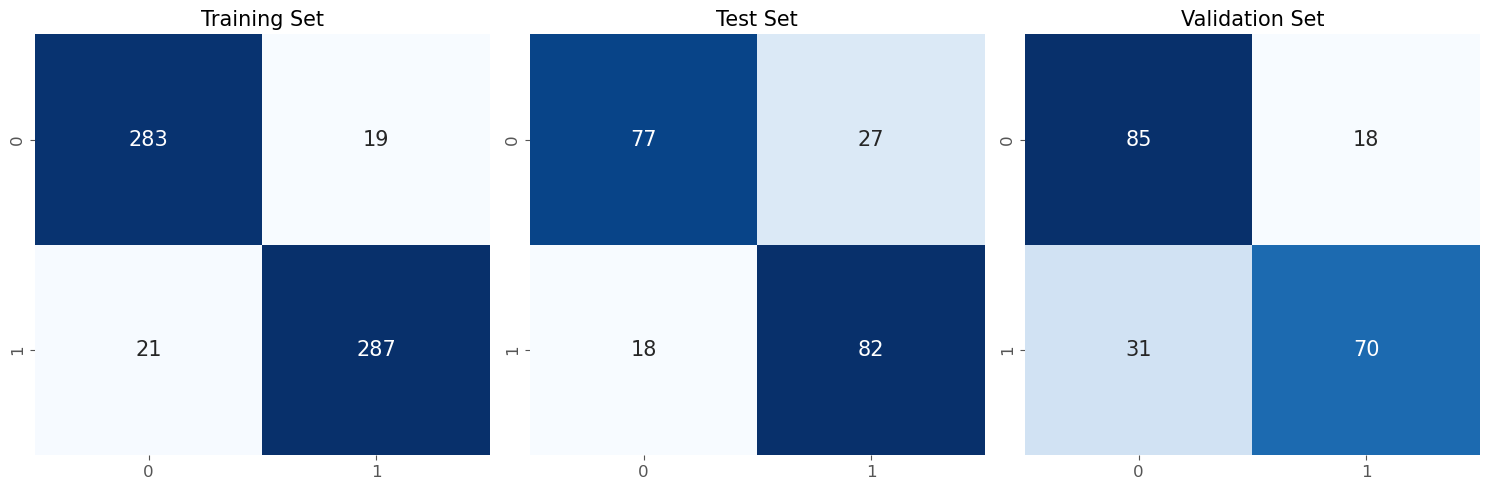

In [119]:
# compute confusion matrix for training / test / validation sets
confusion_train = confusion_matrix(y_train, train_preds.round())
confusion_test = confusion_matrix(y_test, test_preds.round())
confusion_val = confusion_matrix(y_val, validation_preds.round())


# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot training set confusion matrix
sns.heatmap(confusion_train, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[0])
axes[0].set_title('Training Set', fontsize=15)  # Adjust title font size

# Plot test set confusion matrix
sns.heatmap(confusion_test, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[1])
axes[1].set_title('Test Set', fontsize=15)  # Adjust title font size

# Plot validation set confusion matrix
sns.heatmap(confusion_val, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[2])
axes[2].set_title('Validation Set', fontsize=15)  # Adjust title font size

# Adjust tick label font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)

# Display the plots
plt.tight_layout()
plt.show()




As we can see from the various metrics used to measure the goodness of our model, it would seem that ultilizing the values of the tfidf matrix obtained by transforming the articles in the dataset, leads to very good performance. 

Considering for example the accuracy, we see that we get an accuracy of about 93 percent on the training set, so we are not overfitting, and very quite high accuracy values even on data not seen before, that is, on the testset and validation set examples, where we succeed in classifying about 76 percent of the example data.

Upon closer examination of the confusion matrices, we observe a balanced distribution of misclassified examples, regarding false positives and false negatives. Notably, there is no discernible inclination to categorize the majority of examples as either 1 or 0, a pattern consistently observed across the test and validation sets too.

In conclusion, the TF-IDF matrix emerges as a promising feature set for training the logistic regression model.

### NEW FEATURES

List of features to extract: 
1. Features that identify diversity and richness in the vocabulary 
    - MaaS
    - Simpson's index

2. Perplexity 
3. Grammar Score 
4. Type Token Ratio (TTR) on N-grams for N=1,2,3
5. Length (article - level: done in the eda, column 'words')
6. Average token length

Everything done on partially pre-procesed articles: only no punctuation but we keep the stopwords.

Before getting the features, we add some columns to the dataset that containg infromations needed to compute more then one feature. We will drop these columns afterwards. 

In [49]:
# article_clean as a list, useful
data['article_list'] = data.article_nopunct.apply(str.split)


Computing the vocabulary

In [50]:
if False:
    vocabulary = Counter(reduce(lambda x,y : x+y, data.article_list.values))

    # get the vocabulary length and its log (for Herdan's C and MaaS)
    voc_len = len(vocabulary)
    log_voc_len = np.log(voc_len)


Computing the features

In [51]:
if False: 
    # Herdan's C
    data['herdan'] = data.words.apply(lambda row: log_voc_len/np.log(row))

    # MaaS
    data['maas'] = data.words.apply(lambda row: (log_voc_len - np.log(row)) / np.log((voc_len**2)) )

    # Simpson's index 
    data['tf'] = data.article_list.apply(lambda row: Counter(row))
    data['tf'] = data.tf.apply(lambda row: row.values())
    simpson_help = zip(data.tf, list(data.words))
    data['simpson'] = list(simpson_help)
    data['simpson'] = data.simpson.apply(lambda row: [(val/row[1])**2 for val in row[0]]).apply(lambda row: 1-sum(row))

    # Grammar score 
    tool = language_tool_python.LanguageTool('en-US')
    data['grammar_score'] = data.article.apply(lambda row: len(tool.check(row))) #number of errors per row
    grammar_score_help = zip(data.grammar_score, data.words)
    data['grammar_score'] = list(grammar_score_help)
    data['grammar_score'] = data.grammar_score.apply(lambda row: (row[0]/row[1]) ) #compute grammar score

    # TTR on the whole text = on 1-grams (saved as TTR1)
    # for this section: type = len(tf), token = words
    data['TTR1'] = list(zip(list(data.tf.apply(len)), data.words))  #assign (type, token) as value for each row
    data['TTR1'] = data.TTR1.apply(lambda row: row[0]/row[1])       #compute TTR

    # TTR on 2-grams, prevalence of 2grams
    data['bigrams'] = data.article_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 2)) #create bigrams for each document
    data['TTR2'] = data.bigrams.apply(Counter                                     #count the occurency of each bigram
                                    ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                    ).apply(lambda row: row[0]/row[1] )                #computes TTR


    #TTR on 3-grams, prevalence of trigrams
    data['trigrams'] = data.article_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 3)) #create bigrams for each document
    data['TTR3'] = data.trigrams.apply(Counter                                    #count the occurencies of each trigram
                                    ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                    ).apply(lambda row: row[0]/row[1] )                #computes TTR


    # Average token length 
    data['avg_token_length'] = data.article_list.apply(lambda row: [len(word) for word in row]).apply(lambda row: sum(row)/len(row))

    # Perplexity 
    scorer = lmppl.LM('gpt2')
    data['perplexity'] = data.article.apply(scorer.get_perplexity)

    # dropping columns we don't need anymore
    data.drop(['bigrams', 'trigrams', 'tf'], axis=1, inplace=True)

In [53]:
if False: 
    # csv with all the colums from the eda + new features
    data.to_csv('data1000_withfeatures.csv')
    
    # csv with only the features + class (no artile and preprocessed article)
    data1 = data.copy()
    data1.drop(['article', 'article_clean', 'article_nopunct', 'article_list'], axis=1, inplace=True)
    data1.to_csv('data1000_onlyfeaturesandclass.csv')

### LOGISTIC REGRESSION with the NEW FEATURES

Read the dataset with the new computed features

In [28]:
df2 = pd.read_csv("data1000_withfeatures.csv" , index_col= False )
df2.drop(['Unnamed: 0', 'article', 'article_clean', 'total_bigram_count', 'article_nopunct', 'article_list'], axis=1, inplace=True)
df2.head(5)

,class,length,words,sentences,herdan,maas,simpson,grammar_score,TTR1,TTR2,TTR3,avg_token_length,perplexity
0,0,1112,187,6,1.778976,0.218939,0.984157,0.021390,0.609626,0.988235,1.0,4.804348,35.369075
1,0,630,82,2,2.111778,0.263233,0.978882,0.036585,0.768293,1.000000,1.0,6.250000,58.814785
2,0,1135,176,8,1.799834,0.222197,0.985182,0.022727,0.693182,0.989691,1.0,5.285714,53.423985
3,0,1018,173,10,1.805839,0.223120,0.986100,0.034682,0.647399,0.987013,1.0,4.779762,34.250844
4,0,699,111,3,1.975996,0.246963,0.982225,0.027027,0.702703,0.983607,1.0,5.284404,25.693995


Split the data into training / test / validation sets

In [29]:
# 'class' is the target variable and the rest of the columns are used as features
X = df2.drop('class', axis=1)
y = df2['class']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

Standardization and bias addiction

In [30]:
# Standardize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Add a column of ones to the features for the bias term
X_train_scaled_bias = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled_bias = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]
X_val_scaled_bias = np.c_[np.ones(X_val_scaled.shape[0]), X_val_scaled]

#### Hyperparameters Tuning

In [31]:
flag = True

if flag:
    # Define a grid of hyperparameter values to search
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    num_steps_values = [1000, 2000, 3000, 4000, 5000]

    best_params = None
    best_accuracy = 0

    # Perform grid search
    for lr in learning_rates:
        for num_steps in num_steps_values:
            # Initialize parameters
            theta = np.random.normal(0, 0.01, X_train.shape[1])

            # Perform gradient ascent
            theta_final, log_likelihood_history = gradient_ascent(theta, X_train, y_train, lr, num_steps)

            # Make predictions on the validation set
            val_preds = predictions(X_val, theta_final)

            # Calculate accuracy on the validation set
            accuracy = np.mean(val_preds.round() == y_val)
            
            print("lr:", lr, "num_steps:", num_steps, "accuracy:", accuracy)
            
            # Update best parameters if the current combination is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'learning_rate': lr, 'num_steps': num_steps}

    # Print the best hyperparameters
    print("Best Hyperparameters:", best_params)

lr: 0.0001 num_steps: 1000 accuracy: 0.6372549019607843
lr: 0.0001 num_steps: 2000 accuracy: 0.8480392156862745
lr: 0.0001 num_steps: 3000 accuracy: 0.7745098039215687
lr: 0.0001 num_steps: 4000 accuracy: 0.7794117647058824
lr: 0.0001 num_steps: 5000 accuracy: 0.7843137254901961
lr: 0.001 num_steps: 1000 accuracy: 0.7892156862745098
lr: 0.001 num_steps: 2000 accuracy: 0.8774509803921569
lr: 0.001 num_steps: 3000 accuracy: 0.8774509803921569
lr: 0.001 num_steps: 4000 accuracy: 0.5882352941176471
lr: 0.001 num_steps: 5000 accuracy: 0.7009803921568627
lr: 0.01 num_steps: 1000 accuracy: 0.5735294117647058
lr: 0.01 num_steps: 2000 accuracy: 0.8774509803921569
lr: 0.01 num_steps: 3000 accuracy: 0.5833333333333334
lr: 0.01 num_steps: 4000 accuracy: 0.8921568627450981
lr: 0.01 num_steps: 5000 accuracy: 0.6274509803921569
lr: 0.1 num_steps: 1000 accuracy: 0.7794117647058824
lr: 0.1 num_steps: 2000 accuracy: 0.8774509803921569
lr: 0.1 num_steps: 3000 accuracy: 0.8774509803921569
lr: 0.1 num_step

Initialize theta and the hyperparamenters with the best combination given by the tuning

In [32]:
# Initialize theta 
theta = np.random.normal(0, 0.01, X_train_scaled_bias.shape[1])

# Set hyperparameters
print("Hyperparameters:", "lr:", best_params['learning_rate'], "; num_iter:", best_params['num_steps'])

learning_rate = best_params['learning_rate']
num_steps = best_params['num_steps']

Hyperparameters: lr: 0.01 ; num_iter: 4000


Perform the gradient ascent to find the final values for theta

In [33]:
# Perform logistic regression on the training set
theta_final, log_likelihood_history = gradient_ascent(theta, X_train_scaled_bias, y_train, learning_rate, num_steps)

Make prediction on the training / test / validation sets

In [34]:
# Make predictions on the training set
train_preds = predictions(X_train_scaled_bias, theta_final)

# Make predictions on the test set
test_preds = predictions(X_test_scaled_bias, theta_final)

# Evaluate the model on the validation set
validation_preds = predictions(X_val_scaled_bias, theta_final)

Now we evaluate the performances of the logistic regression model, using different metrics:

1) Accuracy:<br>
number of correct classified examples over total number of examples

In [35]:
accuracy_train = np.mean(train_preds.round() == y_train)
print(f'Accuracy training-set: {accuracy_train:.2%}')

accuracy_test = np.mean(test_preds.round() == y_test)
print(f'Accuracy test-set: {accuracy_test:.2%}')

accuracy_val = np.mean(validation_preds.round() == y_val)
print(f'Accuracy validation-set: {accuracy_val:.2%}')

Accuracy training-set: 95.41%
Accuracy test-set: 94.12%
Accuracy validation-set: 96.57%


2) Precision:<br>
(True Positives) / (True Positives + False Positives)

In [36]:
precision_train = np.sum((train_preds.round() == 1) & (y_train == 1)) / np.sum(train_preds.round() == 1)
print(f'Precision training-set: {precision_train:.2%}')

precision_test = np.sum((test_preds.round() == 1) & (y_test == 1)) / np.sum(test_preds.round() == 1)
print(f'Precision test-set: {precision_test:.2%}')

precision_val = np.sum((validation_preds.round() == 1) & (y_val == 1)) / np.sum(validation_preds.round() == 1)
print(f'Precision validation-set: {precision_val:.2%}')


Precision training-set: 94.30%
Precision test-set: 89.29%
Precision validation-set: 93.52%


3) Recall (Sensitivity):<br>
(True Positives) / (True Positives + False Negatives)

In [37]:
recall_train = np.sum((train_preds.round() == 1) & (y_train == 1)) / np.sum(y_train == 1)
print(f'Recall training-set: {recall_train:.2%}')

recall_test = np.sum((test_preds.round() == 1) & (y_test == 1)) / np.sum(y_test == 1)
print(f'Recall test-set: {recall_test:.2%}')

recall_val = np.sum((validation_preds.round() == 1) & (y_val == 1)) / np.sum(y_val == 1)
print(f'Recall validation-set: {recall_val:.2%}')

Recall training-set: 96.75%
Recall test-set: 100.00%
Recall validation-set: 100.00%


4) F1 Score:<br>
(precision * recall) / (precision + recall)

In [38]:
f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)
print(f'F1 Score training-set: {f1_score_train:.2%}')

f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print(f'F1 Score test-set: {f1_score_test:.2%}')

f1_score_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)
print(f'F1 Score validation-set: {f1_score_val:.2%}')

F1 Score training-set: 95.51%
F1 Score test-set: 94.34%
F1 Score validation-set: 96.65%


5) Confusion Matrix:


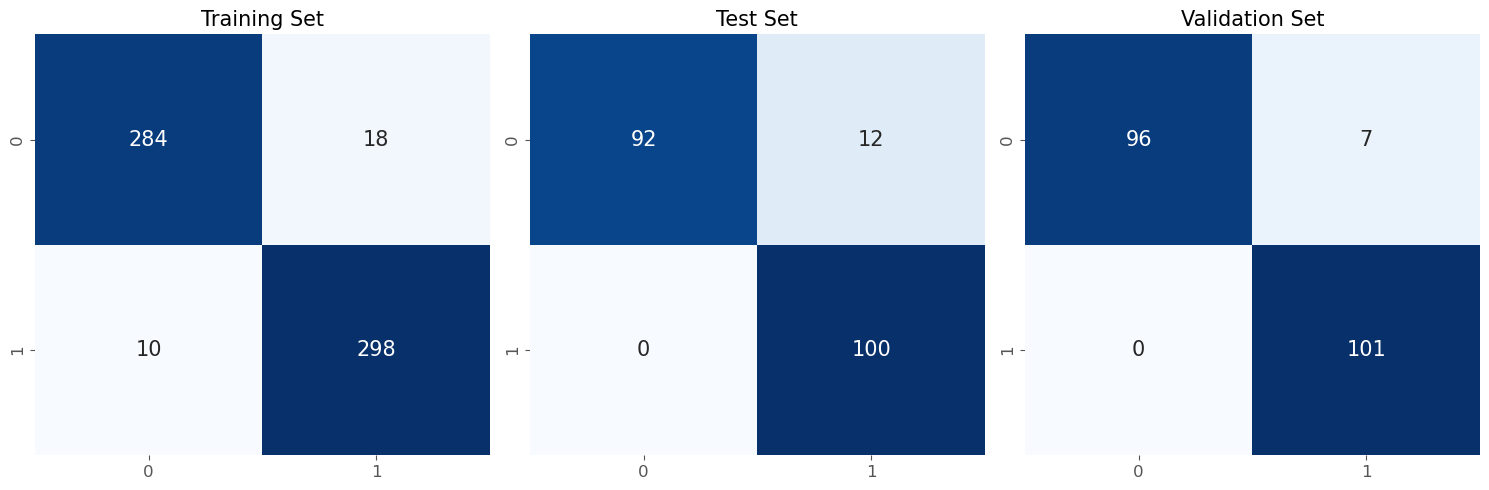

In [39]:
# Compute confusion matrix for training / test / validation sets
confusion_train = confusion_matrix(y_train, train_preds.round())
confusion_test = confusion_matrix(y_test, test_preds.round())
confusion_val = confusion_matrix(y_val, validation_preds.round())


# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot training set confusion matrix
sns.heatmap(confusion_train, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[0])
axes[0].set_title('Training Set', fontsize=15)  # Adjust title font size

# Plot test set confusion matrix
sns.heatmap(confusion_test, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[1])
axes[1].set_title('Test Set', fontsize=15)  # Adjust title font size

# Plot validation set confusion matrix
sns.heatmap(confusion_val, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[2])
axes[2].set_title('Validation Set', fontsize=15)  # Adjust title font size

# Adjust tick label font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)

# Display the plots
plt.tight_layout()
plt.show()


_______________

# Random Forest Algorithm

The Random Forest algorithm is a popular and versatile machine learning method used for both classification and regression tasks. It is an ensemble learning method, which means it combines the predictions from multiple machine learning algorithms to make more accurate predictions than any individual model.

## Overview

A Random Forest consists of a collection of decision trees. The 'forest' generated by the Random Forest is trained through bagging, which involves training each individual tree on a different data sample. Here is how the algorithm works:

### Algorithm Steps:

1. **Bootstrap Aggregating (Bagging)**: Random Forest creates multiple decision trees and merges them together to get a more accurate and stable prediction. For each tree, a random sample of the data is selected (with replacement) to train the tree.

2. **Decision Tree Training**: Each tree in the forest is trained on its bootstrap sample. During the training of these trees, a random subset of features is selected for splitting at each node, adding to the diversity among the trees.

3. **Prediction**:
   - In classification tasks, each tree in the forest votes for a class, and the class with the most votes becomes the model's prediction.
   - In regression tasks, the average prediction of the individual trees is used.

4. **Reduction of Overfitting**: Due to the averaging of multiple trees and the random subset of features chosen for splitting, Random Forests are less likely to overfit compared to a single decision tree.

## Parameter Tuning

Key parameters in a Random Forest include:

- Number of trees in the forest (`n_estimators`)
- Maximum depth of trees (`max_depth`)
- Minimum samples required to split an internal node (`min_samples_split`)
- Minimum samples required to be at a leaf node (`min_samples_leaf`)
- Number of features to consider when looking for the best split (`max_features`)

Optimizing these parameters can significantly impact the performance of a Random Forest model.

## Advantages

- Handles both classification and regression tasks.
- Provides a good indicator of feature importance.
- Handles missing values and maintains accuracy for missing data.
- Less likely to overfit.

## Disadvantages

- Complexity: More complex than Decision Trees.
- Computationally intensive, especially with a large number of trees.
- Less intuitive: The decision-making process is not as easy to understand compared to a single decision tree.


## TF-IDF

In [67]:
# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


In order to apply the Random forest model on the data obtained after the tfidf-vectorization process, we leverage the dataframe used for logistic regression. This way we are also able to compare the results obtained from the two models in a proper way. Recall that the dataframe used for this purpose is called 'df'.

In [68]:
df.head(10)

,class,00,000,05,06,0stripe,10,100,101,1012,1015,102,1024,106,10see,11,1101001,111,11101001,11111,115,11a,11b,11see,12,120,1200,123,128,13,130,135particular,137while,1394,14,144,147,148,15,150,155,16,160,162,165,166,17,175,18,180,...,wrote,wsdl,wto,www,wysiwyg,x10,xbox,xcode,xcopi,xd,xerox,xga,xhtm,xiaomi,xiv,xml,xmodem,xnu,xor,xp,xperia,xrml,y2k,yahoo,yang,yard,ye,year,yellow,yield,york,young,younger,youngster,youtub,yukihiro,z1,z2,z3,z4,zdnet,zero,zimmermann,zip,zone,zoom,zsoft,zuckerberg,zuse,zuseus
0,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.112059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.106704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0.0,0.1076,0.0,0.0,0.0,0.092603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Spliting data

In [69]:
# 'class' is the target variable and the rest of the columns are used as features
X = df.drop('class', axis=1)
y = df['class']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

### Random Forest

In [70]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest.
    'max_depth': [10, 20, None],       # Maximum number of levels in tree.
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at each leaf node.
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split.
    'bootstrap': [True, False]         # Method of selecting samples for training each tree.
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_grid = grid_search.best_estimator_
y_train_pred = best_grid.predict(X_train)  
y_val_pred = best_grid.predict(X_val)
y_test_pred = best_grid.predict(X_test)

# Evaluate the best model after hyperparameter tuning
print("Tuned Training Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred, digits=4))

print("Tuned Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Tuned Validation Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

print("Tuned Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Tuned Test Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))


Fitting 3 folds for each of 324 candidates, totalling 972 fits


Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Tuned Training Accuracy: 0.9983606557377049
              precision    recall  f1-score   support

           0     0.9967    1.0000    0.9983       302
           1     1.0000    0.9968    0.9984       308

    accuracy                         0.9984       610
   macro avg     0.9983    0.9984    0.9984       610
weighted avg     0.9984    0.9984    0.9984       610

Tuned Validation Accuracy: 0.8676470588235294
Tuned Validation Classification Report:
              precision    recall  f1-score   support

           0     0.8958    0.8350    0.8643       103
           1     0.8426    0.9010    0.8708       101

    accuracy                         0.8676       204
   macro avg     0.8692    0.8680    0.8676       204
weighted avg     0.8695    0.8676    0.8675       204

Tuned Test Accuracy: 0.8823529411764706
Tuned Test Classification R

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier with the best parameters found
rf_classifier = RandomForestClassifier(
    n_estimators=best_grid.n_estimators,
    max_depth=best_grid.max_depth,
    min_samples_split=best_grid.min_samples_split,
    min_samples_leaf=best_grid.min_samples_leaf,
    max_features=best_grid.max_features,
    bootstrap=best_grid.bootstrap,
    random_state=42
)

# Perform k-fold cross-validation
# cv=5 denotes 5 folds
# scoring='accuracy' uses accuracy as the metric for evaluation
scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

# Print the accuracy for each fold
print("Accuracies for each fold:")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score}")

# The mean score and the 95% confidence interval of the score estimate are then calculated
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracies for each fold:
Fold 1: 0.8921568627450981
Fold 2: 0.9068627450980392
Fold 3: 0.8431372549019608
Fold 4: 0.8029556650246306
Fold 5: 0.896551724137931
Accuracy: 0.87 (+/- 0.08)


### Plotting of results

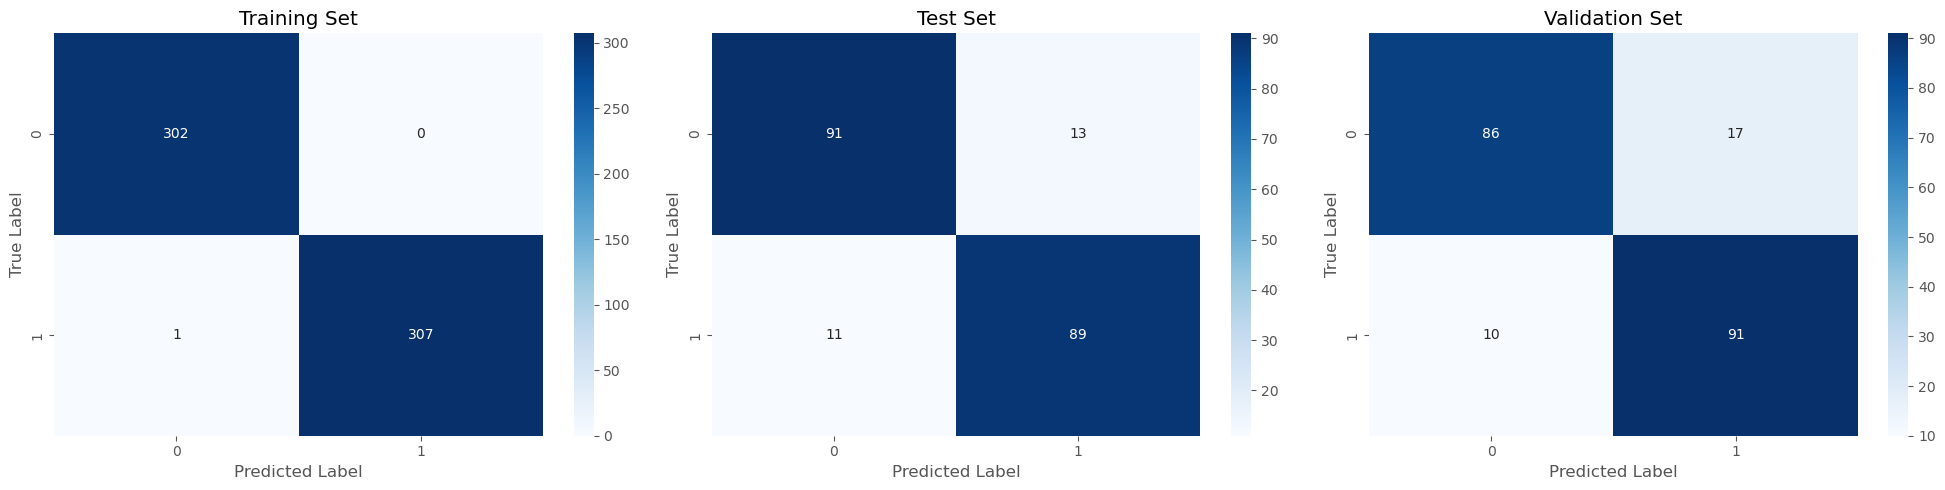

In [72]:
# Calculate confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot confusion matrices
plt.sca(axes[0])
plot_confusion_matrix(conf_matrix_train, 'Training Set')

plt.sca(axes[1])
plot_confusion_matrix(conf_matrix_test, 'Test Set')

plt.sca(axes[2])
plot_confusion_matrix(conf_matrix_val, 'Validation Set')
plt.tight_layout()
plt.show()


### Spliting data

In [73]:
df = df.loc[:, ~df.columns.duplicated()] # remove duplicates columns

# 'class' is the target variable and the rest of the columns are used as features
X = df.drop('class', axis=1)
y = df['class']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

### Random Forest (TFIDF)

In [74]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest.
    'max_depth': [10, 20, None],       # Maximum number of levels in tree.
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at each leaf node.
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split.
    'bootstrap': [True, False]         # Method of selecting samples for training each tree.
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_grid = grid_search.best_estimator_
y_train_pred = best_grid.predict(X_train)  
y_val_pred = best_grid.predict(X_val)
y_test_pred = best_grid.predict(X_test)

# Evaluate the best model after hyperparameter tuning
print("Tuned Training Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred, digits=4))

print("Tuned Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Tuned Validation Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

print("Tuned Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Tuned Test Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))


Fitting 3 folds for each of 324 candidates, totalling 972 fits


Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Tuned Training Accuracy: 0.9983606557377049
              precision    recall  f1-score   support

           0     0.9967    1.0000    0.9983       302
           1     1.0000    0.9968    0.9984       308

    accuracy                         0.9984       610
   macro avg     0.9983    0.9984    0.9984       610
weighted avg     0.9984    0.9984    0.9984       610

Tuned Validation Accuracy: 0.8676470588235294
Tuned Validation Classification Report:
              precision    recall  f1-score   support

           0     0.8958    0.8350    0.8643       103
           1     0.8426    0.9010    0.8708       101

    accuracy                         0.8676       204
   macro avg     0.8692    0.8680    0.8676       204
weighted avg     0.8695    0.8676    0.8675       204

Tuned Test Accuracy: 0.8823529411764706
Tuned Test Classification R

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier with the best parameters found
rf_classifier = RandomForestClassifier(
    n_estimators=best_grid.n_estimators,
    max_depth=best_grid.max_depth,
    min_samples_split=best_grid.min_samples_split,
    min_samples_leaf=best_grid.min_samples_leaf,
    max_features=best_grid.max_features,
    bootstrap=best_grid.bootstrap,
    random_state=42
)

# Perform k-fold cross-validation
# cv=5 denotes 5 folds
# scoring='accuracy' uses accuracy as the metric for evaluation
scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

# Print the accuracy for each fold
print("Accuracies for each fold:")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score}")

# The mean score and the 95% confidence interval of the score estimate are then calculated
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracies for each fold:
Fold 1: 0.8921568627450981
Fold 2: 0.9068627450980392
Fold 3: 0.8431372549019608
Fold 4: 0.8029556650246306
Fold 5: 0.896551724137931
Accuracy: 0.87 (+/- 0.08)


### Plotting of results

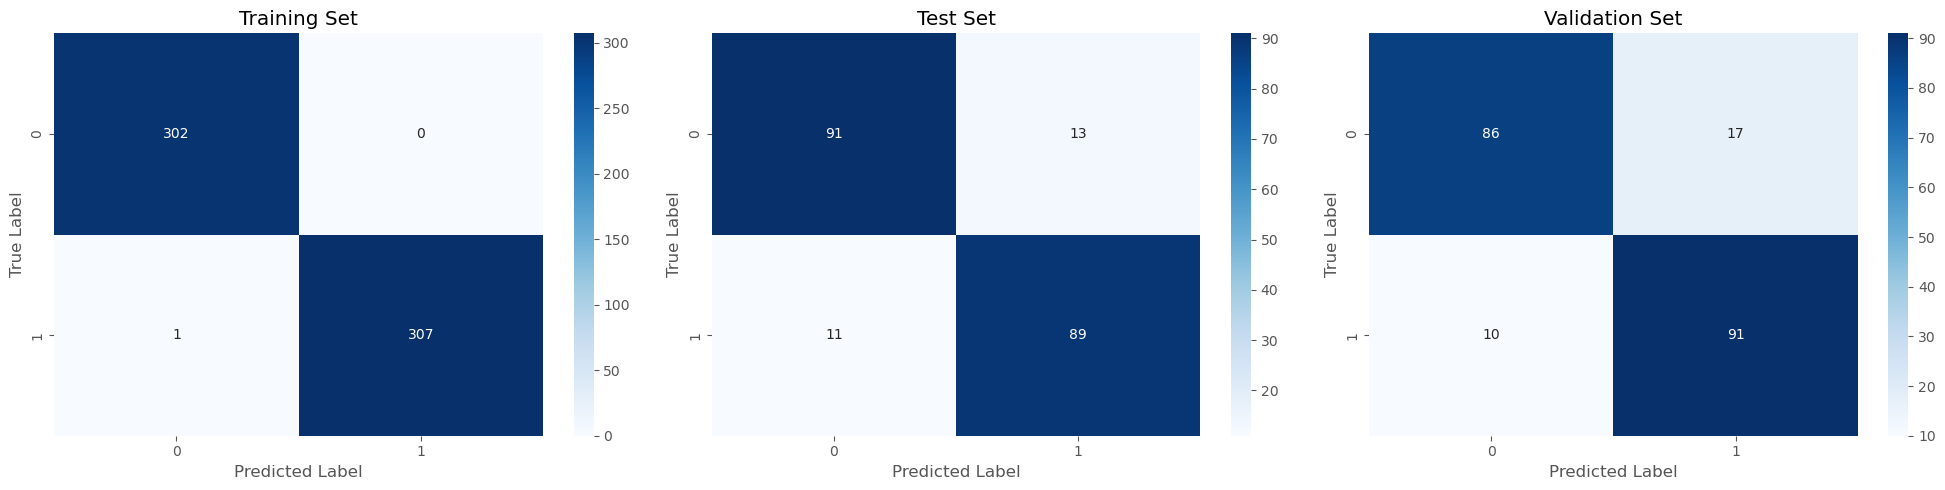

In [76]:
# Calculate confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot confusion matrices
plt.sca(axes[0])
plot_confusion_matrix(conf_matrix_train, 'Training Set')

plt.sca(axes[1])
plot_confusion_matrix(conf_matrix_test, 'Test Set')

plt.sca(axes[2])
plot_confusion_matrix(conf_matrix_val, 'Validation Set')
plt.tight_layout()
plt.show()


## Using new features

List of features to extract: 
1. Features that identify diversity and richness in the vocabulary
    - MaaS
    - Simpson's index

2. Perplexity 
3. Grammar Score 
4. Type Token Ratio (TTR) on N-grams for N=1,2,3
5. Length (article - level: done in the eda, column 'words')
6. Average token length

Everything done on partially pre-procesed articles: only no punctuation but we keep the stopwords.

### Random Forest with new features

Read the dataset with the new computed features

In [41]:
data = pd.read_csv('data1000_withfeatures.csv')

In [42]:
df2 = data.copy()
df2 = df2.drop(columns=[ "article", "article_clean", "total_bigram_count", "article_nopunct", "article_list", "Unnamed: 0"])
df2.head(5)

,class,length,words,sentences,herdan,maas,simpson,grammar_score,TTR1,TTR2,TTR3,avg_token_length,perplexity
0,0,1112,187,6,1.778976,0.218939,0.984157,0.021390,0.609626,0.988235,1.0,4.804348,35.369075
1,0,630,82,2,2.111778,0.263233,0.978882,0.036585,0.768293,1.000000,1.0,6.250000,58.814785
2,0,1135,176,8,1.799834,0.222197,0.985182,0.022727,0.693182,0.989691,1.0,5.285714,53.423985
3,0,1018,173,10,1.805839,0.223120,0.986100,0.034682,0.647399,0.987013,1.0,4.779762,34.250844
4,0,699,111,3,1.975996,0.246963,0.982225,0.027027,0.702703,0.983607,1.0,5.284404,25.693995


Split the data into training / test / validation sets

In [44]:
# 'class' is the target variable and the rest of the columns are used as features
X = df2.drop('class', axis=1)
y = df2['class']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

### Random Forest

In [46]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest.
    'max_depth': [10, 20, None],       # Maximum number of levels in tree.
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at each leaf node.
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split.
    'bootstrap': [True, False]         # Method of selecting samples for training each tree.
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)
#print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_grid = grid_search.best_estimator_
y_train_pred = best_grid.predict(X_train)  
y_val_pred = best_grid.predict(X_val)
y_test_pred = best_grid.predict(X_test)

# Evaluate the best model after hyperparameter tuning
print("Tuned Training Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred, digits=4))

print("Tuned Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Tuned Validation Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

print("Tuned Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Tuned Test Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))


Fitting 3 folds for each of 324 candidates, totalling 972 fits


Tuned Training Accuracy: 0.9967213114754099
              precision    recall  f1-score   support

           0     0.9967    0.9967    0.9967       302
           1     0.9968    0.9968    0.9968       308

    accuracy                         0.9967       610
   macro avg     0.9967    0.9967    0.9967       610
weighted avg     0.9967    0.9967    0.9967       610

Tuned Validation Accuracy: 0.9803921568627451
Tuned Validation Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9612    0.9802       103
           1     0.9619    1.0000    0.9806       101

    accuracy                         0.9804       204
   macro avg     0.9810    0.9806    0.9804       204
weighted avg     0.9811    0.9804    0.9804       204

Tuned Test Accuracy: 0.9656862745098039
Tuned Test Classification Report:
              precision    recall  f1-score   support

           0     0.9802    0.9519    0.9659       104
           1     0.9515    0.9800

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier with the best parameters found
rf_classifier = RandomForestClassifier(
    n_estimators=best_grid.n_estimators,
    max_depth=best_grid.max_depth,
    min_samples_split=best_grid.min_samples_split,
    min_samples_leaf=best_grid.min_samples_leaf,
    max_features=best_grid.max_features,
    bootstrap=best_grid.bootstrap,
    random_state=42
)

# Perform k-fold cross-validation
# cv=5 denotes 5 folds
# scoring='accuracy' uses accuracy as the metric for evaluation
scores = cross_val_score(rf_classifier, X, y, cv=10, scoring='accuracy')

# Print the accuracy for each fold
print("Accuracies for each fold:")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score}")

# The mean score and the 95% confidence interval of the score estimate are then calculated
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracies for each fold:
Fold 1: 1.0
Fold 2: 0.9803921568627451
Fold 3: 1.0
Fold 4: 1.0
Fold 5: 1.0
Fold 6: 0.9411764705882353
Fold 7: 0.9705882352941176
Fold 8: 0.9607843137254902
Fold 9: 0.9306930693069307
Fold 10: 0.9702970297029703
Accuracy: 0.98 (+/- 0.05)


### Plotting

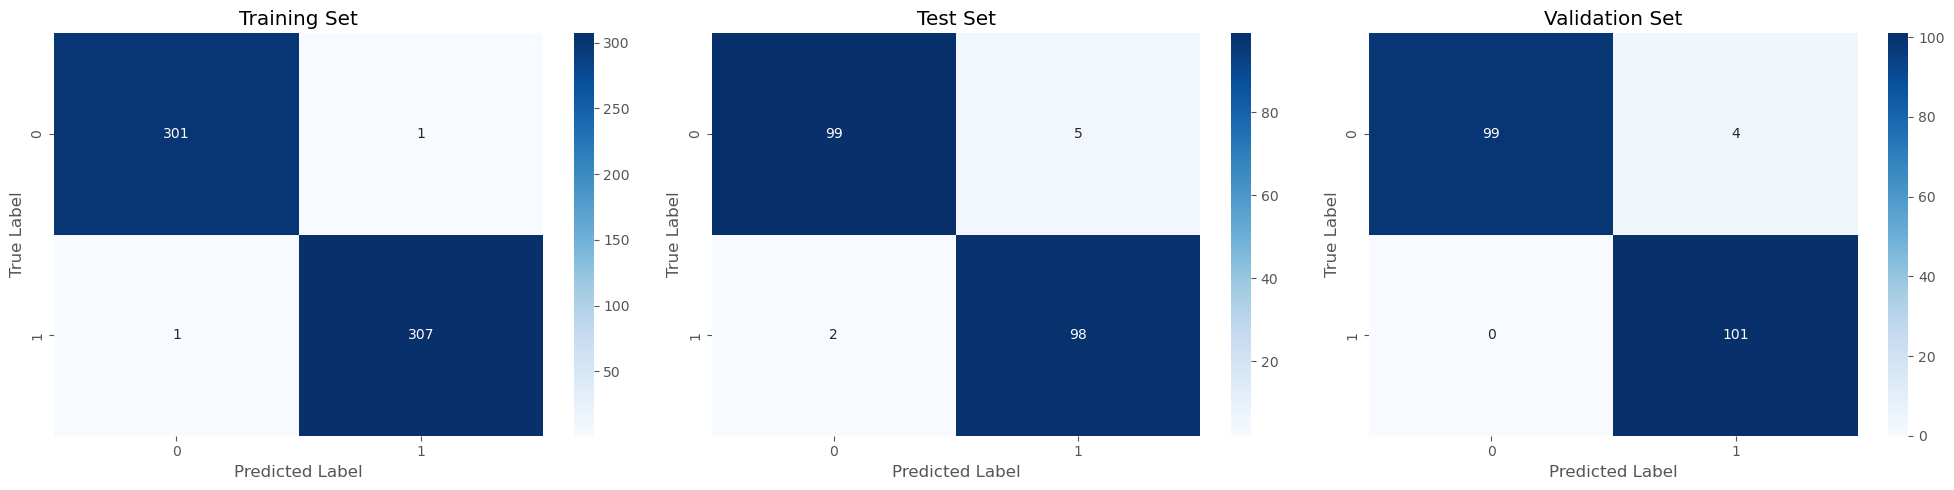

In [48]:
# Calculate confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot confusion matrices
plt.sca(axes[0])
plot_confusion_matrix(conf_matrix_train, 'Training Set')

plt.sca(axes[1])
plot_confusion_matrix(conf_matrix_test, 'Test Set')

plt.sca(axes[2])
plot_confusion_matrix(conf_matrix_val, 'Validation Set')
plt.tight_layout()
plt.show()


# Features importance and permutation importance

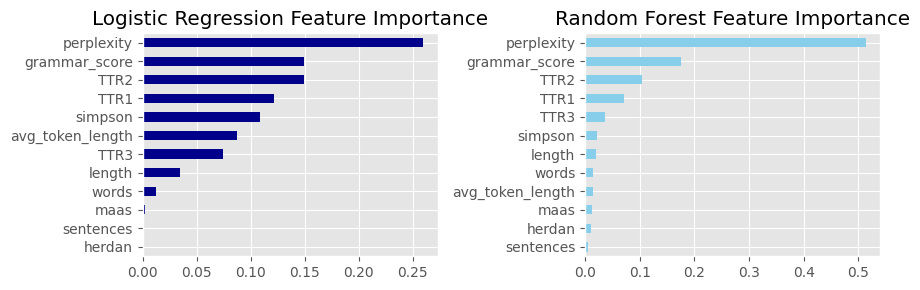

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(9, 3))

# Logistic regression
df_analysis = df2.copy()
df_analysis.drop('class', axis=1, inplace=True)

# Rescaling importance by to have numbers from 0 to 1
theta_analysis = np.abs(theta_final[1:]) / sum(np.abs((theta_final[1:])))  # first element of theta should be the bias; 
feature_importance = pd.Series(theta_analysis, index=df_analysis.columns)
feature_importance = feature_importance.sort_values(ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', color='darkblue', ax=axes[0])
axes[0].set_title("Logistic Regression Feature Importance")

# Random forest
rf_classifier.fit(X_train, y_train)
global_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot(x='Feature', y='Importance', kind='barh', color='skyblue', ax=axes[1])
axes[1].set_title("Random Forest Feature Importance")

plt.tight_layout()